In [1]:
import numpy as np
from sklearn.datasets import make_moons

def create_data(N):
    """
    Esta función retorna E y T, donde cada uno es una tupla con datos, etiquetas
    """
    x, y = make_moons(n_samples=N, shuffle=True, noise=0.25, random_state=1234)
    x = (x - np.mean(x, axis=0, keepdims=True))/np.std(x, axis=0, keepdims=True)
    
    return (x[:N//4], y[:N//4]), (x[N//4:], y[N//4:])


def KNN(X, Y, Z, k=5, p=2.):
    C = np.unique(Y)
    N, D = X.shape
    M, _ = Z.shape
    dist = np.zeros(shape=(M, N))
    for i in range(M):
        for j in range(N):
            dist[i, j] = np.power(np.sum(np.power(np.absolute(Z[i] - X[j]), p)), 1./p)
    neighbours = np.argsort(dist, axis=1)[:, :k]
    Z_Y = np.zeros(shape=(M, ))
    for i in range(M):
        criterion = np.zeros(shape=(len(C),))
        for c in C:
            criterion[c] = np.sum(1./dist[i, neighbours[i]][Y[neighbours[i]] == c])
        Z_Y[i] = np.argmax(criterion)
    return Z_Y

### Considere la implementación "ingenua" del algoritmo KNN que se adjunta a esta tarea con los parámetros $p$ y $k$ por defecto

####  Use la función adjunta `create_data` para crear un conjunto de `N=1000` datos

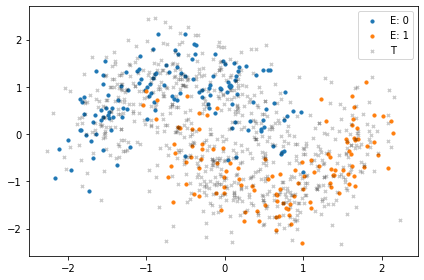

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt

E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
z, w = T # Use las etiquetas w para evaluar sus resultados finales

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for c in np.unique(y):
    mask = y == c
    ax.scatter(x[mask, 0], x[mask, 1], label=f"E: {c}", s=10)
ax.scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2, label='T')
ax.legend();

#### Realice un profiling completo de la función `KNN` usando las magias `timeit`, `prun` y `lprun`

In [4]:
 %timeit -r10 -n5 KNN(x,y,z)

1.93 s ± 30.5 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [5]:
%prun -s cumtime KNN(x,y,z)

In [6]:
%load_ext line_profiler
%lprun -f KNN KNN(x,y,z)

####  Reporte sus resultados y comente sobre los cuellos de botella del algoritmo

Los resultados de los profiling calculados utilizando los datos obtenidos del punto 1 son los siguientes:
   - Mediante la mágia timeit obtuvimos un tiempo de ejecución promedio de 1.57 s 
   - La mágia prun mostró que aquellas funciones relacionadas con arrays fueron las que tuvieron un mayor tiempo en ejecución, en especial la función sum, la cual ocupó un total de 1.112 s.
   - La mágia lprun muestra que el mayor cuello de botella se encuentra en la linea que calcula la distancia entre $z_i$ y cada elemento de $X$, el cual ocupa un 94,6% del tiempo total, es seguido por la linea que corresponde al ciclo for que cambia los indices de $X$, el cual ocupa un 4.1% del tiempo total y lo sigue la linea que  corresponde al calculo de la sumatoria que entrega la clase de $z_i$ 
   
Con estos resultados podemos concluir que existe un evidente cuello de botella que puede ser optimizado, esto se debe a la mala optimizacion con el trabajo de arrays.

### Implemente una nueva versión de la función `KNN`

#### Utilice `Cython` con tipos fijos, vistas de arreglos y funciones de la librería estándar matemática de `C`

In [3]:
%load_ext cython

In [ ]:
%%cython

import cython
cimport numpy as npc
import numpy as np

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO2_t
TIPO2 = np.int64

from libc.math cimport abs
cdef extern from "math.h":
    TIPO_t pow (TIPO_t, TIPO_t)

    
# Deshabilitamos las comprobaciones de Python:
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)


def partition(TIPO_t [::1] arr, TIPO2_t [::1] arr_index, TIPO2_t l, TIPO2_t r):
    cdef TIPO_t piv = arr[r]
    cdef TIPO2_t p = l-1
    for i in range(l,r):
        if(arr[i] <= piv):
            p+=1
            arr[p], arr[i] = arr[i], arr[p]
            arr_index[p], arr_index[i] = arr_index[i], arr_index[p] 
    arr[p+1], arr[r] = arr[r], arr[p+1]
    arr_index[p+1], arr_index[r] = arr_index[r], arr_index[p+1] 
    return p+1

def quicksort(TIPO_t [::1] arr, TIPO2_t [::1] arr_index, TIPO2_t l, TIPO2_t r):
    cdef TIPO2_t lenarr = len(arr)
    cdef TIPO2_t p
    if lenarr == 1:
        return arr
    if(l<r):
        p = partition(arr, arr_index, l, r)
        quicksort(arr, arr_index, l, p-1)
        quicksort(arr, arr_index, p+1, r)


def cython_KNN2(TIPO_t [:, ::1] X, TIPO2_t [::1] Y, TIPO_t [:, ::1] Z, TIPO2_t k = 5, TIPO_t p = 2):
    cdef TIPO2_t [::1] C = np.unique(Y)
    cdef TIPO2_t lenC = len(C)
    cdef int N = X.shape[0]
    cdef int D = X.shape[1]
    cdef int M = Z.shape[0]
    cdef TIPO_t criterion
    cdef TIPO_t maximo_criterion

    dist = np.zeros(shape=(M, N), dtype=TIPO)
    dist2 = np.zeros(shape=(M, N), dtype=TIPO)
    cdef TIPO_t [:, ::1] dist_cython = dist
    cdef TIPO_t [:, ::1] dist2_cython = dist2
    cdef TIPO2_t lendist 
    cdef TIPO2_t [::1] neighbours = np.empty(shape=(k,), dtype=TIPO2)
    cdef Py_ssize_t i, j, d

    Z_Y = np.empty(shape=(M,), dtype=TIPO)
    cdef TIPO_t [::1] Z_Y_cython = Z_Y

    for i in range(M):
        for j in range(N):
            dist_cython[i,j] = 0
            for d in range(D):
                dist_cython[i,j] += pow(abs(Z[i][d] - X[j][d]),p)
                dist2_cython[i,j] += pow(abs(Z[i][d] - X[j][d]),p)
            dist_cython[i,j] = pow(dist_cython[i,j],1./p)
            dist2_cython[i,j] = pow(dist_cython[i,j],1./p)
        lendist = len(dist_cython[i])
        ind = np.arange(0,lendist)
        neighbours = ind
        quicksort(dist2_cython[i], neighbours, 0,lendist-1)
        maximo_criterion = 0.0
        for c in range(lenC):
            criterion = 0.0
            for h in range(k):
                if(Y[neighbours[h]] == C[c]):
                    criterion += 1./dist_cython[i,neighbours[h]]
            if(maximo_criterion < criterion):
                maximo_criterion = criterion
                Z_Y_cython[i] = C[c]
    return Z_Y

In [66]:
%%cython

import cython
cimport numpy as npc
import numpy as np

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO2_t
TIPO2 = np.int64

from libc.math cimport abs
cdef extern from "math.h":
    TIPO_t pow (TIPO_t, TIPO_t)

    
# Deshabilitamos las comprobaciones de Python:
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def cython_KNN(TIPO_t [:, ::1] X, TIPO2_t [::1] Y, TIPO_t [:, ::1] Z, TIPO2_t k = 5, TIPO_t p = 2):
    cdef TIPO2_t [::1] C = np.unique(Y)
    cdef TIPO2_t lenC = len(C)
    cdef int N = X.shape[0]
    cdef int D = X.shape[1]
    cdef int M = Z.shape[0]
    cdef TIPO_t criterion
    cdef TIPO_t maximo_criterion

    dist = np.zeros(shape=(M, N), dtype=TIPO)
    cdef TIPO_t [:, ::1] dist_cython = dist
    cdef TIPO2_t [::1] neighbours = np.empty(shape=(k,), dtype=TIPO2)
    cdef Py_ssize_t i, j, d

    Z_Y = np.empty(shape=(M,), dtype=TIPO)
    cdef TIPO_t [::1] Z_Y_cython = Z_Y

    for i in range(M):
        for j in range(N):
            dist_cython[i,j] = 0
            for d in range(D):
                dist_cython[i,j] += pow(abs(Z[i][d] - X[j][d]),p)
            dist_cython[i,j] = pow(dist_cython[i,j],1./p)

        neighbours = np.argsort(dist_cython[i])[:k]
        maximo_criterion = 0.0
        for c in range(lenC):
            criterion = 0.0
            for h in range(k):
                if(Y[neighbours[h]] == C[c]):
                    criterion += 1./dist_cython[i,neighbours[h]]
            if(maximo_criterion < criterion):
                maximo_criterion = criterion
                Z_Y_cython[i] = C[c]
    return Z_Y

In [64]:
%timeit -r10 -n5 cython_KNN(x,y,z)

22.9 ms ± 738 µs per loop (mean ± std. dev. of 10 runs, 5 loops each)


#### Muestre que obtiene el mismo resultado que la versión original

In [6]:
if(np.allclose(cython_KNN(x,y,z),KNN(x,y,z))):
    print("Se obtiene el mismo resultado con las funciones KNN y cython_KNN")

Se obtiene el mismo resultado con las funciones KNN y cython_KNN


#### Grafique el *speed-up* de su nueva función con respecto a la implementación "inocente" original para $N=[10, 50, 100, 500, 1000, 5000, 10000]$

In [7]:
N = [50, 100, 500, 1000, 5000]
tiempos = np.zeros((2,5))
for i, n in enumerate(N):
    E, T = create_data(n)
    x, y = E
    z, w = T
    print("Para N = ",n)
    print("KNN : ",end="")
    segundosKNN = %timeit -r5 -o KNN(x, y, z)
    print("Cython_KNN : ",end="")
    segundosCython_KNN = %timeit -r5 -o cython_KNN(x, y, z)
    tiempos[0][i] = segundosKNN.average
    tiempos[1][i] = segundosCython_KNN.average

Para N =  50
KNN : 5.62 ms ± 63.6 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)
Cython_KNN : 278 µs ± 2.11 µs per loop (mean ± std. dev. of 5 runs, 1000 loops each)
Para N =  100
KNN : 22.2 ms ± 1.1 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
Cython_KNN : 641 µs ± 41.5 µs per loop (mean ± std. dev. of 5 runs, 1000 loops each)
Para N =  500
KNN : 486 ms ± 10 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
Cython_KNN : 6.79 ms ± 342 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)
Para N =  1000
KNN : 1.88 s ± 25.2 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
Cython_KNN : 23.8 ms ± 1.66 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
Para N =  5000
KNN : 46.3 s ± 513 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
Cython_KNN : 528 ms ± 2.65 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


Text(0, 0.5, 'Porcentaje\n')

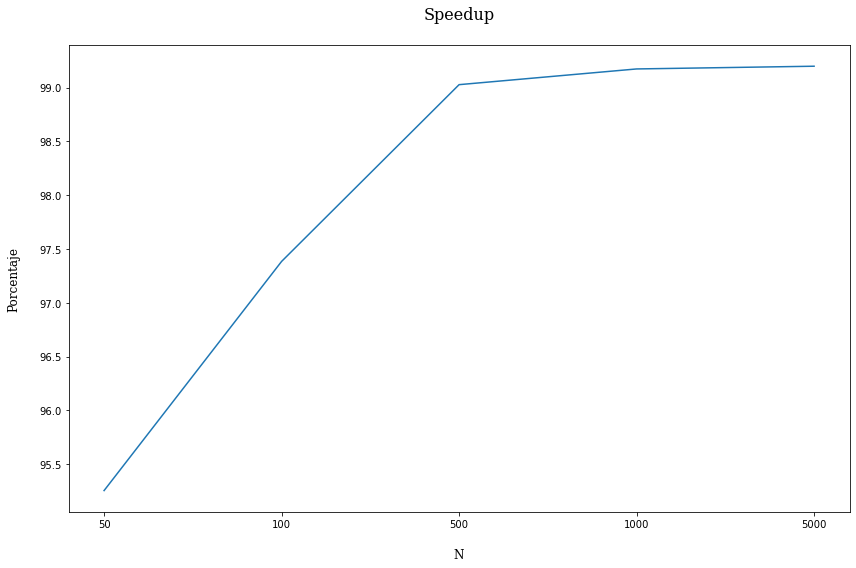

In [109]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(12,8))

speedup = 100 * np.divide(tiempos[0]-tiempos[1],tiempos[0])

#speedup
ax.plot(range(5),speedup)
ax.set_title("Speedup\n", fontsize=16, fontname='serif')
ax.set_xticks(range(5))
ax.set_xticklabels(N)
ax.set_xlabel('\nN', fontsize=12, fontname='serif')
ax.set_ylabel('Porcentaje\n', fontsize=12, fontname='serif')
#ax.set_yscale('log')

### Usando la nueva versión de `KNN` y el conjunto de `N=1000` datos creados con `create_data` realice una validación cruzada en el conjunto $E$ para encontrar el mejor valor de los parámetros $k$ y $p$

In [79]:
import numpy as np
from sklearn.model_selection import train_test_split

N=1000
E, T = create_data(N)
x, y = E # Use E para realizar validación cruzada
z, w = T # Use las etiquetas w para evaluar sus resultados finales


### Evalue su mejor clasificador en el conjunto $T$ y haga un reporte completo de resultados que incluya curvas ROC y las métricas vistas en el curso. Muestre una gráfica de la frontera de decisión de su clasificador en el rango $[(-2,2), (-2,2)]$